## FBPINN for solving the following ODEs
$ \left\{ \begin{array}{l}
u''(x) =  - \sin (\pi x),\,\,\,\,\,x \in (0,1),\\
u(0) = 0,\,\,\,u(1) = 0.
\end{array} \right. $

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [10]:
tf.keras.backend.set_floatx('float64')
np.random.seed(0)
tf.random.set_seed(0)

In [11]:
# Problem setup
N = 3  # Number of subdomains
domain = [0.0, 1.0]
overlap = 0.2
num_points = 200
sigma = 0.1

In [12]:
# Define subdomain centers and bounds
centers = np.linspace(domain[0], domain[1], N)
bounds = [(max(domain[0], c - overlap), min(domain[1], c + overlap)) for c in centers]

In [13]:
# RHS function
def f(x):
    return -tf.sin(np.pi * x)

# Constraint to enforce u(0) = u(1) = 0
def apply_constraint(x, u):
    return x * (1 - x) * u

# Window functions (normalized Gaussians)
def window_functions(x):
    x = tf.expand_dims(x, 1)  # shape: (B, 1)
    c = tf.constant(centers, dtype=tf.float64)[None, :]  # shape: (1, N)
    w = tf.exp(-((x - c) ** 2) / sigma**2)
    return w / tf.reduce_sum(w, axis=1, keepdims=True)  # shape: (B, N)

# Subdomain-specific input normalization
def normalize(x, a, b):
    return 2.0 * (x - a) / (b - a) - 1.0

In [14]:
# Define a simple MLP
def build_model():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])

In [15]:
# Create local models and optimizers
models = [build_model() for _ in range(N)]
optimizers = [tf.keras.optimizers.Adam(0.01) for _ in range(N)]

# Training points
x_train = np.linspace(0, 1, num_points).reshape(-1, 1).astype(np.float64)
x_tf = tf.convert_to_tensor(x_train)

In [16]:
# Training step
@tf.function
def train_step(x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)

        w = window_functions(x[:, 0])  # shape: (B, N)
        u_parts = []

        for i in range(N):
            a, b = bounds[i]
            x_norm = normalize(x[:, 0], a, b)
            x_norm = tf.expand_dims(x_norm, 1)
            u_i = models[i](x_norm)[:, 0]
            u_parts.append(u_i)

        u_parts = tf.stack(u_parts, axis=1)  # shape: (B, N)
        u_combined = tf.reduce_sum(w * u_parts, axis=1)
        u = apply_constraint(x[:, 0], u_combined)

        u_x = tape.gradient(u, x)[:, 0]
        u_xx = tape.gradient(u_x, x)[:, 0]

        residual = u_xx - f(x[:, 0])
        loss = tf.reduce_mean(tf.square(residual))

    for i in range(N):
        grads = tape.gradient(loss, models[i].trainable_variables)
        optimizers[i].apply_gradients(zip(grads, models[i].trainable_variables))

    return loss

In [17]:
# Training loop
for epoch in range(10001):
    loss = train_step(x_tf)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.5e}")

Epoch 0, Loss: 5.33107e+02
Epoch 100, Loss: 6.45213e-01
Epoch 200, Loss: 5.05238e-01
Epoch 300, Loss: 4.30606e-01
Epoch 400, Loss: 3.63365e-01
Epoch 500, Loss: 2.99821e-01
Epoch 600, Loss: 2.41351e-01
Epoch 700, Loss: 1.89118e-01
Epoch 800, Loss: 1.43775e-01
Epoch 900, Loss: 1.05631e-01
Epoch 1000, Loss: 7.47132e-02
Epoch 1100, Loss: 5.07394e-02
Epoch 1200, Loss: 3.30856e-02
Epoch 1300, Loss: 2.08091e-02
Epoch 1400, Loss: 1.27660e-02
Epoch 1500, Loss: 7.78917e-03
Epoch 1600, Loss: 4.85463e-03
Epoch 1700, Loss: 3.17668e-03
Epoch 1800, Loss: 2.22095e-03
Epoch 1900, Loss: 1.66056e-03
Epoch 2000, Loss: 1.31279e-03
Epoch 2100, Loss: 1.08222e-03
Epoch 2200, Loss: 9.20751e-04
Epoch 2300, Loss: 4.05596e+00
Epoch 2400, Loss: 1.04337e-02
Epoch 2500, Loss: 4.25389e-03
Epoch 2600, Loss: 1.92355e-03
Epoch 2700, Loss: 1.03141e-03
Epoch 2800, Loss: 6.98167e-04
Epoch 2900, Loss: 5.74550e-04
Epoch 3000, Loss: 5.26208e-04
Epoch 3100, Loss: 3.42129e-03
Epoch 3200, Loss: 1.24842e-02
Epoch 3300, Loss: 4.53

In [18]:
# Inference
x_test = np.linspace(0, 1, 500).reshape(-1, 1).astype(np.float64)
x_test_tf = tf.convert_to_tensor(x_test)

w_test = window_functions(x_test_tf[:, 0])
u_parts_test = []

In [19]:
for i in range(N):
    a, b = bounds[i]
    x_norm = normalize(x_test_tf[:, 0], a, b)
    x_norm = tf.expand_dims(x_norm, 1)
    u_i = models[i](x_norm)[:, 0]
    u_parts_test.append(u_i)

u_parts_test = tf.stack(u_parts_test, axis=1)
u_blended = tf.reduce_sum(w_test * u_parts_test, axis=1)
u_pred = apply_constraint(x_test_tf[:, 0], u_blended)

# True solution
u_true = np.sin(np.pi * x_test) / (np.pi ** 2)

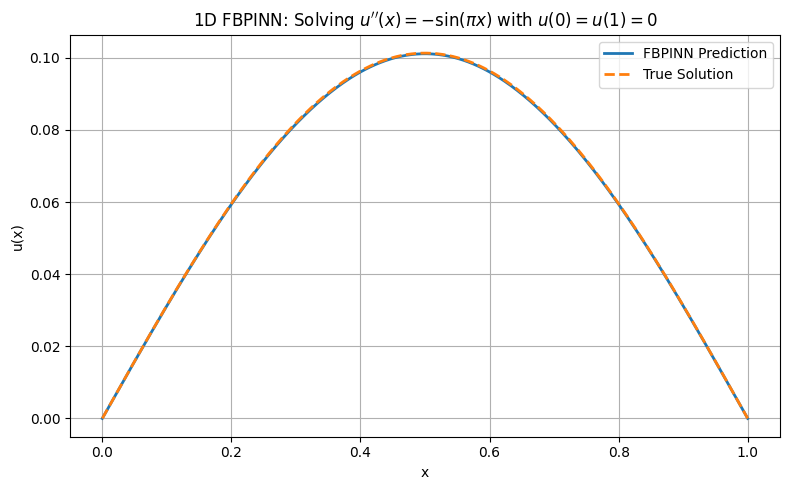

In [20]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_test, u_pred.numpy(), label="FBPINN Prediction", linewidth=2)
plt.plot(x_test, u_true, '--', label="True Solution", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.title("1D FBPINN: Solving $u''(x) = -\sin(\pi x)$ with $u(0)=u(1)=0$")
plt.tight_layout()
plt.show()
